# Mnist分类任务
> + 网络基本构建与训练方法
> + torch.nn.functional模块
> + nn.Mudule模块
> + dataset和dataloader使用

## 读取Mnist数据集

In [1]:
% matplotlib inline

In [6]:
from pathlib import Path
import requests

DataPath = Path('data')
Path = DataPath / "mnist"

Path.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FileName = "mnist.pkl.gz"

if not (Path / FileName).exists():
    content = requests.get(URL + FileName).content
    (Path / FileName).open("wb").write(content)

In [7]:
import pickle
import gzip

with gzip.open((Path / FileName).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

**每个样本包含784=28\*28\*1个像素**

(50000, 784) (50000,) (10000, 784) (10000,)


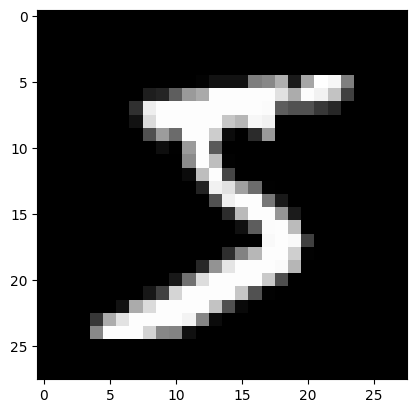

In [9]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

## Mnist分类任务

In [10]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape

## 使用torch.nn.functional 模块
torch.nn.Module和torch.nn.functional都有很多函数，能实现相同功能。一般情况下，如果模型有可学习参数，最好用nn.Module,其他情况用nn.functional相对更简单

In [11]:
import torch.nn.functional as F

loss_func = F.cross_entropy


def model(xb):
    return xb.mm(weights) + bias

In [12]:
bs = 64
xb = x_train[0:bs]
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype=torch.float, requires_grad=True)
bias = torch.zeros(10, requires_grad=True)
print(loss_func(model(xb), yb))

tensor(14.2878, grad_fn=<NllLossBackward>)


## 创建一个Model来简化代码
+ 必须继承nn.Module
+ 无需手写反向传播函数，nn.module能够利用自动求导实现反向传播
+ 可学习参数可通过named_parameters()或parameters()返回迭代器

In [13]:
from torch import nn


class Mnist_NN(nn.Module):
    # 定义构造函数
    def __init__(self):
        # 初始化父类构造函数
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        # self.hidden3 = nn.Linear(256, 10)
        self.out = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [14]:
net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


**可以打印网络里的参数**

In [15]:
for name, parameters in net.named_parameters():
    print(name, parameters, parameters.size())

hidden1.weight Parameter containing:
tensor([[ 0.0165, -0.0182, -0.0321,  ...,  0.0019,  0.0123,  0.0254],
        [ 0.0279,  0.0151, -0.0264,  ...,  0.0148, -0.0174,  0.0125],
        [ 0.0228, -0.0111,  0.0159,  ..., -0.0317,  0.0295,  0.0291],
        ...,
        [-0.0113,  0.0211, -0.0131,  ...,  0.0229, -0.0033,  0.0236],
        [-0.0148, -0.0318, -0.0011,  ..., -0.0356,  0.0259,  0.0285],
        [-0.0017,  0.0218,  0.0245,  ..., -0.0064, -0.0302, -0.0256]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([-2.9609e-02,  3.3518e-02,  2.5609e-02, -3.2586e-02, -2.2396e-02,
        -2.0147e-02,  1.5896e-02, -2.7935e-02,  9.5197e-03,  3.3072e-02,
        -3.1977e-02,  6.7677e-03,  2.5040e-02, -1.3826e-02,  8.4747e-05,
        -1.8728e-02,  1.7111e-03,  5.4635e-03,  2.1416e-02,  2.0805e-02,
        -1.6405e-02, -3.3134e-02, -1.9712e-02,  2.7197e-02,  3.1541e-02,
        -1.5973e-02,  2.8689e-03, -1.8642e-02,  3.4334e-02,  3.1567e-02,
      

## 使用TensorDataset和DataLoader来简化

In [16]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [17]:
def get_data(train_ds, valid_ds, bs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(valid_ds, batch_size=bs * 2),
            )

+ **一般在在训练模型时加上`model.train()`,这样会正常使用Normalization和Dropout**
+ **测试的时候一般选择`model.eval()`,这样就不会使用Normalization和Dropout**


In [18]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)

In [19]:
import numpy as np


def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(f"当前step：{step}，验证集损失：{val_loss}")


In [20]:
from torch import optim


def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

### 训练

In [21]:
model, opt = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step：0，验证集损失：2.2778869674682616
当前step：1，验证集损失：2.2429221740722656
当前step：2，验证集损失：2.188354666137695
当前step：3，验证集损失：2.0980909713745115
当前step：4，验证集损失：1.950851148223877
当前step：5，验证集损失：1.7299544036865235
当前step：6，验证集损失：1.4582110034942628
当前step：7，验证集损失：1.2047766105651856
当前step：8，验证集损失：1.0106034000396729
当前step：9，验证集损失：0.8719275703430176
当前step：10，验证集损失：0.7725068694114685
当前step：11，验证集损失：0.6971979211807251
当前step：12，验证集损失：0.6401853184700013
当前step：13，验证集损失：0.5950704009056091
当前step：14，验证集损失：0.5586960344791413
当前step：15，验证集损失：0.5286416642189026
当前step：16，验证集损失：0.5036317627906799
当前step：17，验证集损失：0.48172946915626524
当前step：18，验证集损失：0.46330577845573423
当前step：19，验证集损失：0.44739595742225646
当前step：20，验证集损失：0.433144797706604
当前step：21，验证集损失：0.4206992911338806
当前step：22，验证集损失：0.4097844927549362
当前step：23，验证集损失：0.3993577396631241
当前step：24，验证集损失：0.3907827751636505
